# Exercise 2 - R: Logistic Regression

## *Part One*: Logistic regression without regularization

Beginning with package imports, data loading, and initial visualization

In [51]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(readr)
  library(ggplot2)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

In [52]:
df <- read_csv("~/Projects/Machine Learning/machine-learning-ex2/ex2/ex2data1.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Exam1Score', 'Exam2Score', 'Admitted')

# Inserting ones for the intercept
df <- cbind(Intercept=1, df)

X <- df %>% select(-Admitted)
y <- df$Admitted

# An array of 0s for starting values of theta to be used in many functions
initialTheta <- c(0,0,0)

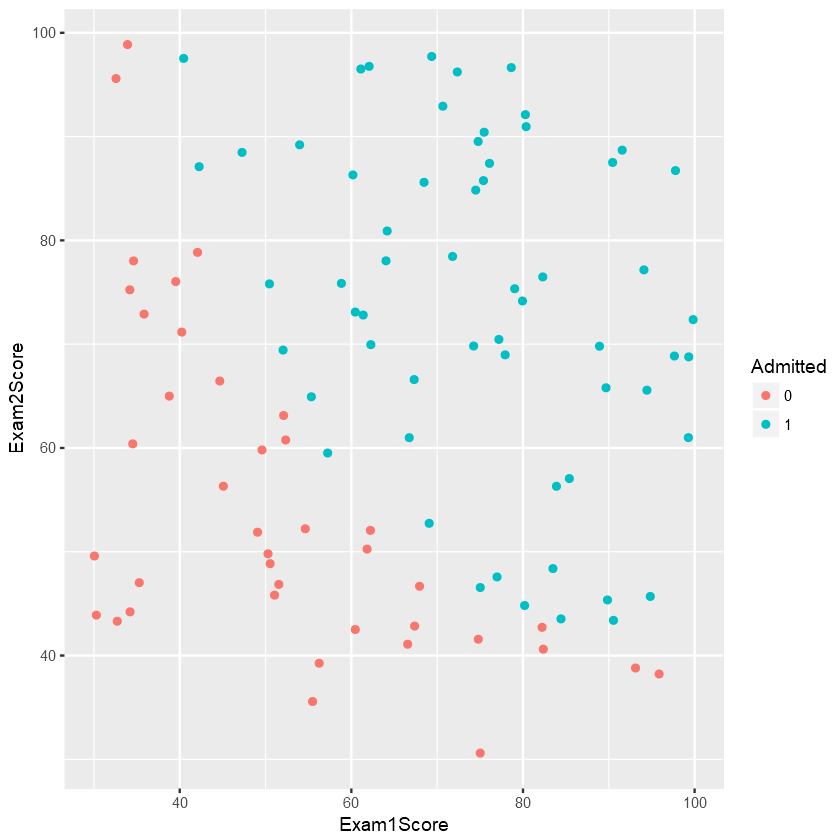

In [53]:
ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') 

### Sigmoid Function

$g(z) = \frac{1}{1+e^{-z}}$

Converts $z$ into a value between 0 and 1

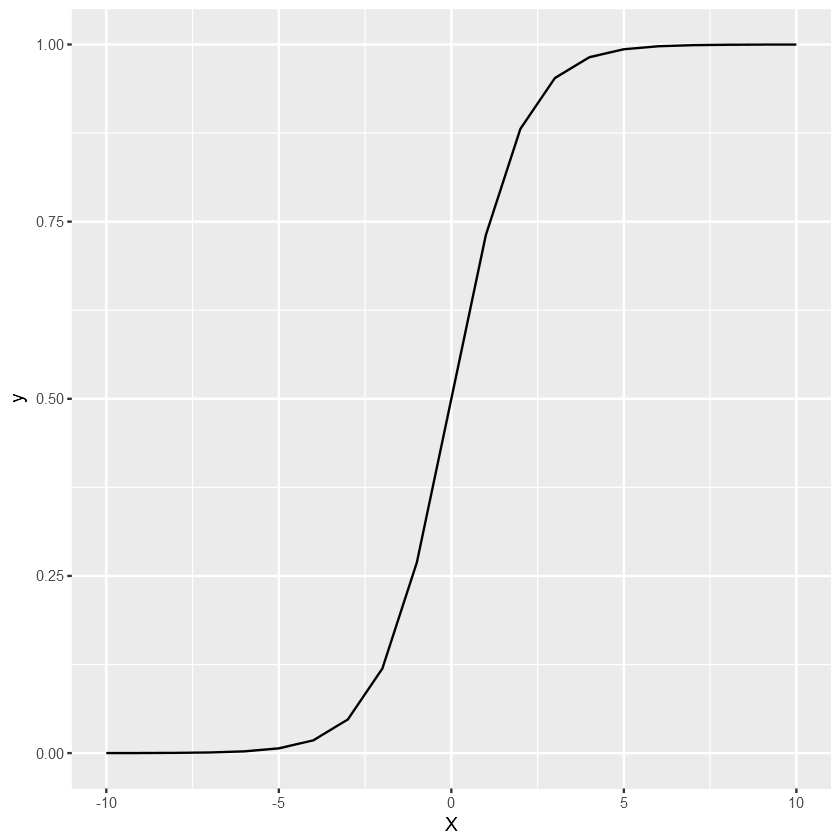

In [54]:
sigmoid <- function(z){
  # Converts numerical input into a value between 0 and 1 
  return(1/(1+exp(-z))) 
}

# Plotting to validate that the function is working
data.frame(X = -10:10) %>% 
  mutate(y = sigmoid(X)) %>% 
  ggplot() + 
    geom_line(aes(x=X, y=y))

### Logistic Regression Hypothesis

$h_\theta(x) = g(\theta^Tx)$

- Notation:

    - $g$: Sigmoid function

    - $\theta^T$: Transposed parameters
       
        - E.x.: $\theta^T = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}$

In [55]:
logistic_hypothesis <- function(theta, X){
  # Calculates the hypothesis for X given values of
  # theta for logistic regression
  X <- as.matrix(X)
  theta <- as.matrix(theta)
  h <- X %*% theta
  return(sigmoid(h))
}

logistic_hypothesis(initialTheta, head(X))

1,0.5
2,0.5
3,0.5
4,0.5
5,0.5
6,0.5


### Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))]$

- Notation:

    - $m$: Number of records

    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [56]:
cost_function <- function(theta, X, y){
  # Computes cost for logistic regression
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  error <- sum(-y*log(h)-(1-y)*log(1-h))
  return((1/m)*error)
}

cost_function(initialTheta, X, y)

[1] 0.6931472

### Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$

- Notation:

    - $\partial$: Partial derivative
    
    - $J(\theta)$: Cost given $\theta$

    - $m$: Number of records
    
    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [57]:
gradient <- function(theta, X, y){
  # Computes the gradient for logistic regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  
  m <- length(y)
  h <- logistic_hypothesis(theta, X)
  
  return((1/m) * (t(X) %*% (h-y)))
}

gradient(initialTheta, X, y)

Intercept,-0.10000
Exam1Score,-12.00922
Exam2Score,-11.26284


Finding the optimal values of $\theta_j$ for the cost function using the base R optim function.  This is similar to MATLAB's fminunc function.

In [59]:
# Find values of theta that minimize the cost function
optimalTheta <- optim(
      # Specifying function parameters
      par=initialTheta,  # Initial guess
      fn=cost_function,  # Function to minimize
      gr=gradient,
      X=X,
      y=y,
      method="BFGS",  #  Optimization function to use
      control = list(maxit = 400)  # Maximum number of iterations
     )$par  # Specifying that we only want the obtained thetas

# Pretty printing the obtained values for theta
cat('Cost:', x = cost_function(optimalTheta, X, y), '\n')
cat('\nOptimal Thetas\n',
    'Intercept:', optimalTheta[1], '\n',
    'Theta 1:', optimalTheta[2], '\n',
    'Theta 2:', optimalTheta[3])

Cost: 0.2034985 

Optimal Thetas
 Intercept: -25.08949 
 Theta 1: 0.205657 
 Theta 2: 0.2008903

Comparing the obtained parameters to what base R's glm function provides

In [60]:
glm(Admitted ~ Exam1Score+Exam2Score, data=df, family=binomial)


Call:  glm(formula = Admitted ~ Exam1Score + Exam2Score, family = binomial, 
    data = df)

Coefficients:
(Intercept)   Exam1Score   Exam2Score  
   -25.1613       0.2062       0.2015  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    134.6 
Residual Deviance: 40.7 	AIC: 46.7

Not bad!

Calculating the class probability and generating predictions of acceptance using values of $\theta_j$ obtained from the optimization function

The outputs from logistic regression are just the class probability, or $P(y = 1 \mid x; \theta)$, so we are predicting the classes (accepted or not) as follows:

$Prediction(y \mid x; \theta) = \begin{cases} 1, \quad\mbox{ if } P(y = 1 \mid x; \theta) > 0.50 \\ 0, \quad\mbox{ if } P(y = 1 \mid x; \theta) \leq 0.50 \end{cases} $

In [61]:
# Predicting the class probability with the obtained thetas
df$ClassProbability <- logistic_hypothesis(optimalTheta, X)

# Assigning those with a class probability above 0.5 as admitted
df$Prediction <- ifelse(df$ClassProbability > 0.5, 1, 0)

head(df)

Intercept,Exam1Score,Exam2Score,Admitted,ClassProbability,Prediction
1,34.62366,78.02469,0,9.158060e-02,0
1,30.28671,43.89500,0,4.349868e-05,0
1,35.84741,72.90220,0,4.428246e-02,0
1,60.18260,86.30855,1,9.903015e-01,1
1,79.03274,75.34438,1,9.981672e-01,1
1,45.08328,56.31637,0,1.093940e-02,0


Plotting the decision boundary over the data

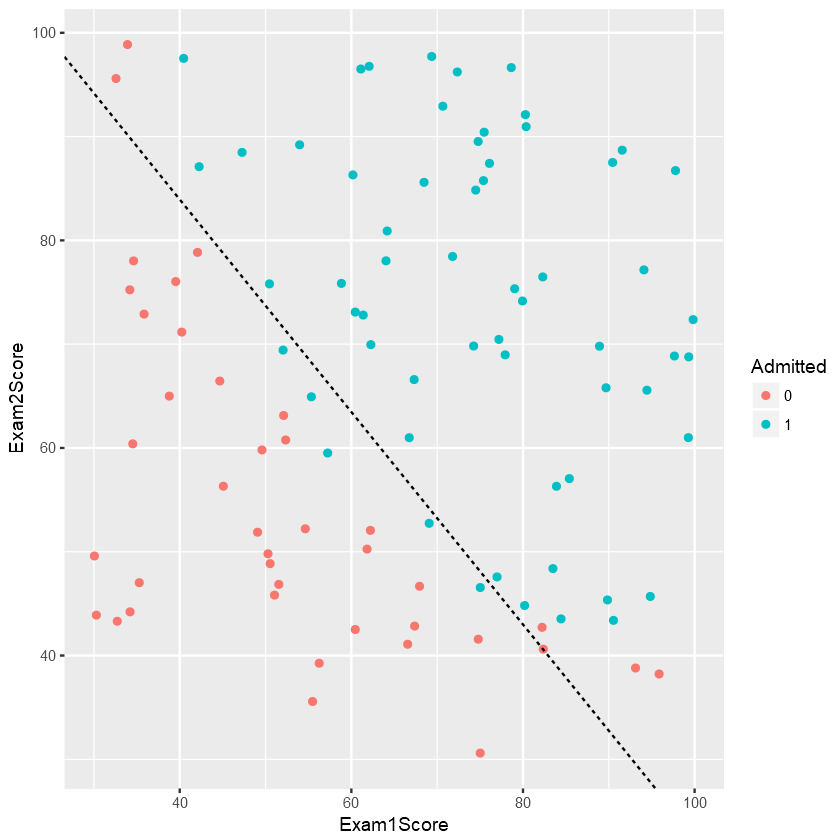

In [71]:
# Calculating and plotting the decision boundary
decisionSlope <- optimalTheta[2]/(-optimalTheta[3])
decisionIntercept <- optimalTheta[1]/(-optimalTheta[3]) 

ggplot(df) +
  geom_point(aes(x=Exam1Score, y=Exam2Score, color=as.factor(Admitted))) + 
  labs(color='Admitted') +
  geom_abline(intercept=decisionIntercept, slope=decisionSlope,
              linetype='dashed')

---

##  **Part 2:** Logistic regression with regularization

Predicting acceptance of microchips based off of two tests

In [72]:
df <- read_csv("~/Projects/Machine Learning/machine-learning-ex2/ex2/ex2data2.txt",
                   col_names = FALSE,
                   col_types = 'ddd')

colnames(df) <- c('Test1', 'Test2', 'Accepted')

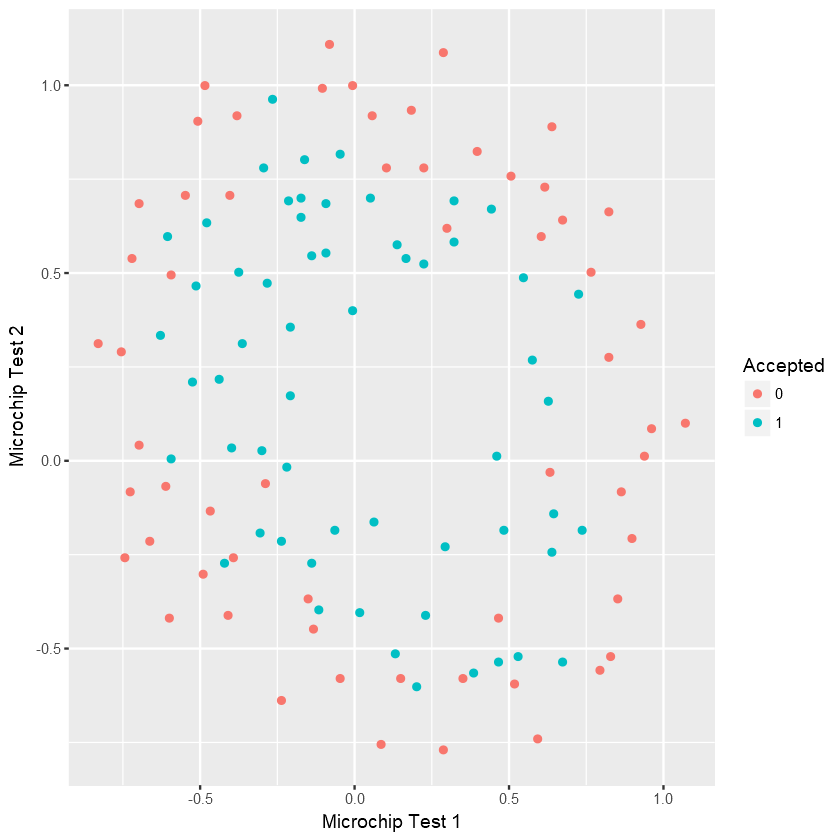

In [73]:
ggplot(df) +
  geom_point(aes(x=Test1, y=Test2, color=as.factor(Accepted))) + 
  labs(color='Accepted') +
  xlab('Microchip Test 1') + 
  ylab('Microchip Test 2')

### Feature Mapping

Maps the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.  This allows for a more complex and nonlinear decision boundary.  

The feature space prior to feature mapping (3-dimensional vector): 

$\hspace{1cm} Feature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix}$ 

The feature space after feature mapping:

$\hspace{1cm} mapFeature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1x_2^5 \\ x_2^6 \end{bmatrix}$

**Note:** The Octave/MATLAB code provided for this assignment resulted in a 28-dimensional feature space, but our code will result in a 49-dimensional feature space.  This is because the Octave/MATLAB code provided *some* interaction terms (e.x. $x_1x_2,\ x_1^3x_2^4$, etc.), but not all possible interaction terms.  For simplicity, we'll use all interaction terms.

Octave/MATLAB code:
```
degree = 6;
out = ones(size(X1(:,1)));
for i = 1:degree
    for j = 0:i
        out(:, end+1) = (X1.^(i-j)).*(X2.^j);
    end
end
```

Corresponding R code:
```
X <- matrix(1,length(df$Test1),1)
  
for (i in 1:degree)
  for (j in 0:i)
    out <- cbind(out, (df$Test1 ^ (i - j)) * (df$Test2 ^ j))

```

In [75]:
degree <- 6

# Generating polynomials for Test #1
test1 <- poly(df$Test1, degree, raw=TRUE) %>% data.frame()
colnames(test1) <- c('x1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x1_6')

# Generating polynomials for Test #2
test2 <- poly(df$Test2, degree, raw=TRUE) %>% data.frame()
colnames(test2) <- c('x2', 'x2_2', 'x2_3', 'x2_4', 'x2_5', 'x2_6')

### Regularized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

The only change from the other cost function we used earlier is the addition of the regularization parameter:

#### Regularization Parameter

$\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

**Note:** $\theta_0$ should not be regularized as denoted by the summation in the regularization parameter

### Regularized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

This is also the same as the last gradient with the exception of the regularization parameter

#### Regularization Parameter

$\frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

Finding the optimal values of $\theta$.  This chunk will take longer to run since we're dealing with a much higher dimensional dataset.

Checking against R's glm logistic regression

R's glm function unsurprisingly found much better parameters.  It also executed much quicker due to being properly optimized.  I guess I shouldn't try contributing to R anytime soon.

Lastly, comparing the accuracy between the two models.  Classification accuracy is just the percentage of records correctly classified (precision, recall, f-1 score, etc. offer more nuanced information on performance), so we will have to calculate the class probabilities and assign predictions like we did for part one:

Our model also had a much lower accuracy like we would have expected.  